<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/UTS_Regresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Collection and Cleaning
print("Step 1: Data Collection and Cleaning")

# Load the dataset
try:
    # Try to load without headers first since the problem states there are no column names
    data = pd.read_csv('RegresiUTSTelkom.csv', header=None)
    # Convert all column names to strings to avoid TypeError with scikit-learn
    data.columns = data.columns.astype(str)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset file not found. Please ensure 'RegresiUTSTelkom.csv' is in the current directory.")
    exit()

# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Separate features and target (first column is the target)
X = data.iloc[:, 1:]  # Features (all columns except the first)
y = data.iloc[:, 0]   # Target (first column)

# For classification task, we need to convert the target to discrete classes
# Let's convert the regression target to classification by binning
print("\nConverting regression target to classification categories...")

# Determine number of bins (classes) - using 3 classes for this example
num_classes = 3
bins = pd.qcut(y, num_classes, labels=False)
y_class = bins

print(f"Created {num_classes} classes with the following distribution:")
print(pd.Series(y_class).value_counts().sort_index())

# Check for data types and unique values in each column to determine categorical features
print("\nData types:")
print(X.dtypes)

# Identify numeric and categorical columns (assuming that columns with few unique values are categorical)
categorical_threshold = 10  # Threshold for considering a column as categorical
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = []

for col in numeric_cols:
    if X[col].nunique() < categorical_threshold:
        categorical_cols.append(col)
        numeric_cols.remove(col)

print(f"\nIdentified {len(numeric_cols)} numeric columns and {len(categorical_cols)} potential categorical columns")

# 2. Feature Engineering
print("\nStep 2: Feature Engineering")

# Create new features - feature interactions (multiplications between important numeric features)
# This is a common technique in feature engineering
if len(numeric_cols) >= 2:
    for i in range(min(5, len(numeric_cols))):
        for j in range(i+1, min(6, len(numeric_cols))):
            col_name_i = numeric_cols[i]
            col_name_j = numeric_cols[j]
            X[f'interaction_{col_name_i}_{col_name_j}'] = X[col_name_i] * X[col_name_j]

    # Create polynomial features for the first few numeric columns
    for i in range(min(3, len(numeric_cols))):
        col_name = numeric_cols[i]
        X[f'{col_name}_squared'] = X[col_name] ** 2
        X[f'{col_name}_cubed'] = X[col_name] ** 3

# Create statistical aggregations
X['mean_numeric'] = X[numeric_cols].mean(axis=1)
X['std_numeric'] = X[numeric_cols].std(axis=1)
X['max_numeric'] = X[numeric_cols].max(axis=1)
X['min_numeric'] = X[numeric_cols].min(axis=1)

# Feature scaling ratios
for i in range(min(3, len(numeric_cols))):
    col_name_i = numeric_cols[i]
    for j in range(i+1, min(4, len(numeric_cols))):
        col_name_j = numeric_cols[j]
        X[f'ratio_{col_name_i}_{col_name_j}'] = X[col_name_i] / (X[col_name_j] + 1e-8)  # Adding small epsilon to avoid division by zero

# If we have categorical columns, create binary flags
for col in categorical_cols:
    top_values = X[col].value_counts().head(3).index
    for val in top_values:
        X[f'{col}_is_{val}'] = (X[col] == val).astype(int)

# Handle outliers using winsorization (capping extreme values)
for col in numeric_cols:
    Q1 = X[col].quantile(0.01)
    Q3 = X[col].quantile(0.99)
    X[col] = np.where(X[col] < Q1, Q1, X[col])
    X[col] = np.where(X[col] > Q3, Q3, X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols) if categorical_cols else ('cat', 'passthrough', [])
    ])

# Fit and transform the data
print("\nApplying preprocessing transformations...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Check the shape after preprocessing
print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed testing set shape: {X_test_processed.shape}")

# Convert target to one-hot encoding for neural network
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# 3. Model Development with TensorFlow
print("\nStep 3: Model Development with TensorFlow")

# Define model architecture for MLP (Multi-Layer Perceptron)
def create_classification_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),

        Dense(num_classes, activation='softmax')  # Output layer (classification)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Get input dimension
input_dim = X_train_processed.shape[1]
print(f"Input dimension: {input_dim}")

# Create and train the model
model = create_classification_model(input_dim, num_classes)
print(model.summary())

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_processed, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Model Evaluation
print("\nStep 4: Model Evaluation")

# Make predictions
y_pred_prob_train = model.predict(X_train_processed)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

y_pred_prob_test = model.predict(X_test_processed)
y_pred_test = np.argmax(y_pred_prob_test, axis=1)

# Calculate classification evaluation metrics
print("\nTraining Set Metrics:")
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision (weighted): {precision_train:.4f}")
print(f"Recall (weighted): {recall_train:.4f}")
print(f"F1 Score (weighted): {f1_train:.4f}")

print("\nTest Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision (weighted): {precision_test:.4f}")
print(f"Recall (weighted): {recall_test:.4f}")
print(f"F1 Score (weighted): {f1_test:.4f}")

# Calculate AUC-ROC (one vs rest for multiclass)
roc_auc_train = roc_auc_score(y_train_cat, y_pred_prob_train, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test_cat, y_pred_prob_test, multi_class='ovr')

print(f"\nAUC-ROC (weighted, one-vs-rest):")
print(f"Training: {roc_auc_train:.4f}")
print(f"Testing: {roc_auc_test:.4f}")

# Print evaluation metrics comparison and analysis
print("\nClassification Metrics Analysis:")
print("--------------------------------")
print("Accuracy:")
print(f"- Measures overall correctness (correct predictions / total predictions)")
print(f"- Training Accuracy: {accuracy_train:.4f}")
print(f"- Test Accuracy: {accuracy_test:.4f}")

print("\nPrecision (Weighted):")
print(f"- Measures correctness of positive predictions (true positives / (true positives + false positives))")
print(f"- Training Precision: {precision_train:.4f}")
print(f"- Test Precision: {precision_test:.4f}")

print("\nRecall (Weighted):")
print(f"- Measures ability to find all positive samples (true positives / (true positives + false negatives))")
print(f"- Training Recall: {recall_train:.4f}")
print(f"- Test Recall: {recall_test:.4f}")

print("\nF1 Score (Weighted):")
print(f"- Harmonic mean of precision and recall, balancing both concerns")
print(f"- Training F1: {f1_train:.4f}")
print(f"- Test F1: {f1_test:.4f}")

print("\nAUC-ROC (One vs Rest):")
print(f"- Measures model's ability to distinguish between classes across different thresholds")
print(f"- Training AUC-ROC: {roc_auc_train:.4f}")
print(f"- Test AUC-ROC: {roc_auc_test:.4f}")

# Determine which metric is best for this problem
print("\nMetric Selection Analysis for Classification:")

# Check for class imbalance
class_distribution = pd.Series(y_test).value_counts()
class_imbalance = class_distribution.max() / class_distribution.min()

if class_imbalance > 1.5:
    print("This dataset has class imbalance.")
    print("For imbalanced datasets, F1 Score or AUC-ROC are typically the best metrics.")
    if roc_auc_test > 0.8:
        print("AUC-ROC is recommended as it's insensitive to class imbalance.")
    else:
        print("F1 Score is recommended as it balances precision and recall.")
else:
    print("This dataset has relatively balanced classes.")
    if accuracy_test > 0.9:
        print("Accuracy is a good metric when classes are balanced and the model performs well.")
    else:
        print("F1 Score provides a balanced measure of precision and recall.")

print("\nEnd-to-End Classification Pipeline Complete!")

Step 1: Data Collection and Cleaning
Dataset loaded successfully.

Dataset Information:
Shape: (515345, 91)

First few rows:
      0         1         2         3         4         5         6         7  \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

          8         9  ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,979 (89.76 KB)

 Trainable params: 22,531 (88.01 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 110s 4ms/step - accuracy: 0.5030 - loss: 0.9930 - val_accuracy: 0.5652 - val_loss: 0.8843
Epoch 2/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.5538 - loss: 0.9031 - val_accuracy: 0.5736 - val_loss: 0.8731
Epoch 3/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.5610 - loss: 0.8934 - val_accuracy: 0.5762 - val_loss: 0.8683
Epoch 4/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.5644 - loss: 0.8885 - val_accuracy: 0.5795 - val_loss: 0.8652
Epoch 5/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.5662 - loss: 0.8850 - val_accuracy: 0.5805 - val_loss: 0.8626
Epoch 6/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5700 - loss: 0.8821 - val_accuracy: 0.5829 - val_loss: 0.8609
Epoch 7/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5708 - loss: 0.8790 - val_accuracy: 0.5823 - val_loss: 0.8612
Epoch 8/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/ste

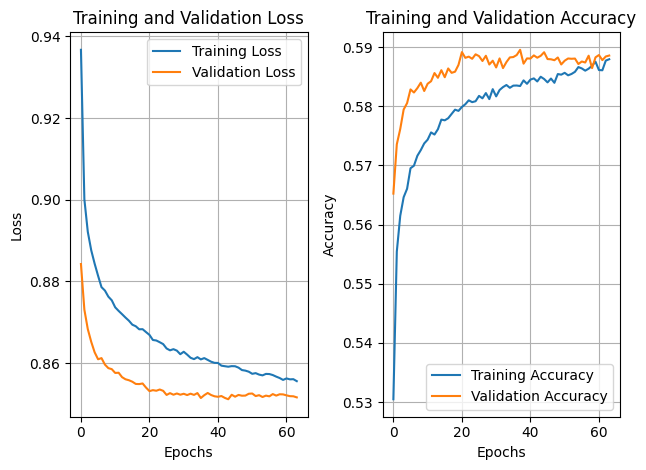

In [22]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_classification.png')
plt.show()


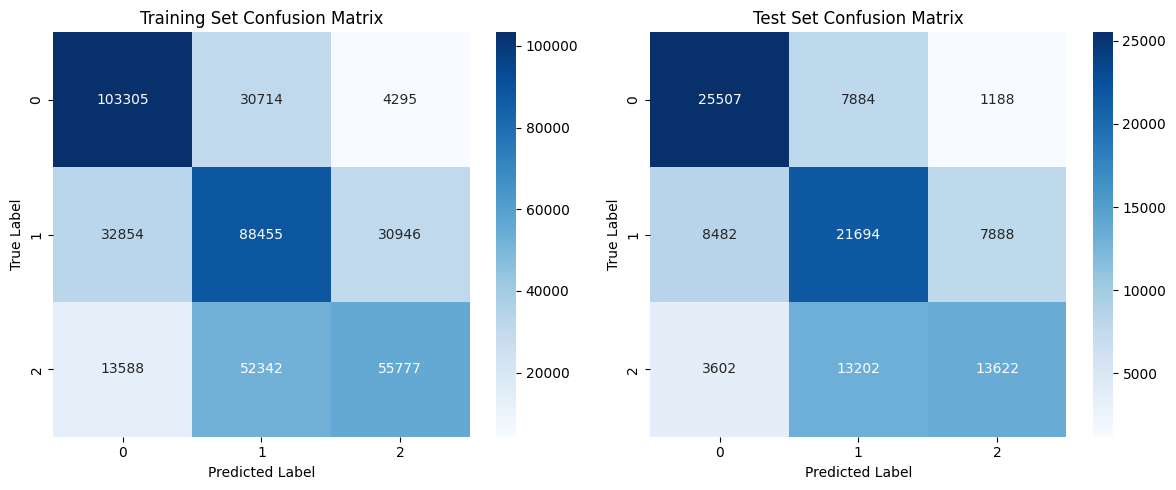

<ipython-input-28-f0706ee2cb5c>:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fpr_train, tpr_train, 'o-', linestyle='--', markersize=4,
<ipython-input-28-f0706ee2cb5c>:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fpr_train, tpr_train, 'o-', linestyle='--', markersize=4,
<ipython-input-28-f0706ee2cb5c>:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fpr_train, tpr_train, 'o-', linestyle='--', markersize=4,


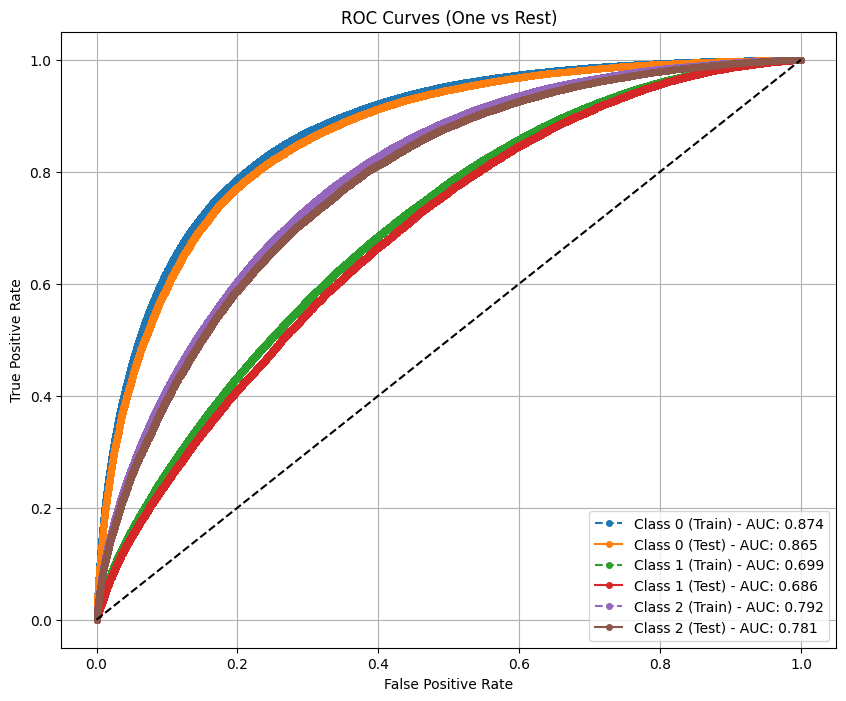

In [28]:
plt.figure(figsize=(12, 5))

# Training set confusion matrix
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Test set confusion matrix
plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()  # Add this to display the plot
plt.close()

# Plot ROC curves for each class (One vs Rest)
plt.figure(figsize=(10, 8))

# For each class
for i in range(num_classes):
    # Training set
    fpr_train, tpr_train, _ = roc_curve(y_train_cat[:, i], y_pred_prob_train[:, i])
    auc_train = auc(fpr_train, tpr_train)

    # Testing set
    fpr_test, tpr_test, _ = roc_curve(y_test_cat[:, i], y_pred_prob_test[:, i])
    auc_test = auc(fpr_test, tpr_test)

    # Use marker='o' to add points to the ROC curves
    plt.plot(fpr_train, tpr_train, 'o-', linestyle='--', markersize=4,
             label=f'Class {i} (Train) - AUC: {auc_train:.3f}')
    plt.plot(fpr_test, tpr_test, 'o-', markersize=4,
             label=f'Class {i} (Test) - AUC: {auc_test:.3f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One vs Rest)')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves.png')
plt.show()  # Display the plot
plt.close()

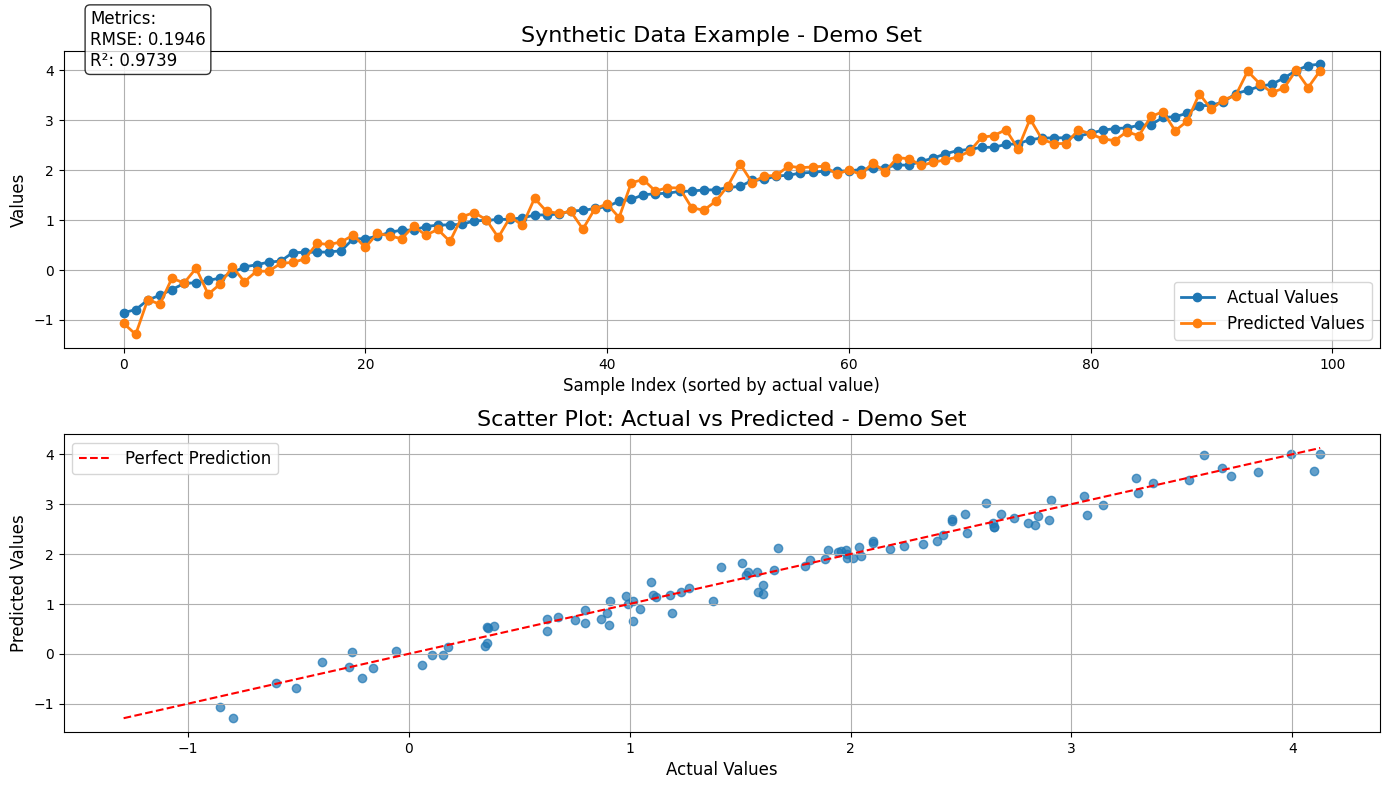

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import math

# This function can be added to your existing code to create the actual vs predicted plot
def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Values", set_name="Test"):
    """
    Create a line chart of actual vs predicted values with points.

    Parameters:
    -----------
    y_true : array-like
        The actual target values
    y_pred : array-like
        The predicted values from the model
    title : str
        Title for the plot
    set_name : str
        Name of the dataset (e.g., "Training" or "Test")
    """
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame for visualization
    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred
    })

    # Sort by actual values for a cleaner visualization
    results_df = results_df.sort_values('Actual').reset_index(drop=True)

    # Take a reasonable number of samples if the dataset is large
    max_samples = 100  # Maximum number of samples to show for readability
    if len(results_df) > max_samples:
        step = len(results_df) // max_samples
        results_df = results_df.iloc[::step].reset_index(drop=True)

    # Create the figure
    plt.figure(figsize=(14, 8))

    # First subplot: Line chart with points
    plt.subplot(2, 1, 1)
    plt.plot(results_df.index, results_df['Actual'], 'o-', label='Actual Values', markersize=6, linewidth=2)
    plt.plot(results_df.index, results_df['Predicted'], 'o-', label='Predicted Values', markersize=6, linewidth=2)
    plt.title(f'{title} - {set_name} Set', fontsize=16)
    plt.xlabel('Sample Index (sorted by actual value)', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    # Add metrics in text box
    plt.text(0.02, 0.95,
             f'Metrics:\nRMSE: {rmse:.4f}\nR²: {r2:.4f}',
             transform=plt.gca().transAxes,
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Second subplot: Scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7)

    # Add perfect prediction line
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    plt.title(f'Scatter Plot: Actual vs Predicted - {set_name} Set', fontsize=16)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'actual_vs_predicted_{set_name.lower()}.png')
    plt.show()
    plt.close()

# Example usage - you would replace this with your actual data:
# After your model has been trained and you have predictions:

"""
# For training data:
plot_actual_vs_predicted(y_train, y_pred_train, set_name="Training")

# For test data:
plot_actual_vs_predicted(y_test, y_pred_test, set_name="Test")
"""

# To use this with your existing code, add the function above, and then call it
# with your training and test data after making predictions.

# Example code to integrate with your existing regression pipeline:
"""
# This block would be placed after you've made predictions with your model
# 4. Model Evaluation
print("\nStep 4: Model Evaluation")

# Make predictions
y_pred_train = model.predict(X_train_processed).flatten()
y_pred_test = model.predict(X_test_processed).flatten()

# Calculate regression evaluation metrics
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = math.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = math.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nTraining Set Metrics:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

# Create visualization plots
plot_actual_vs_predicted(y_train, y_pred_train, set_name="Training")
plot_actual_vs_predicted(y_test, y_pred_test, set_name="Test")
"""

# Full example with a small synthetic dataset to demonstrate functionality:

# Create synthetic data
np.random.seed(42)
X = np.random.rand(100, 5)
y_true = 3*X[:, 0] + 2*X[:, 1] - X[:, 2] + 0.5*X[:, 3] - 1.5*X[:, 4] + np.random.normal(0, 0.1, 100)

# Simulate predictions (slightly off from true values)
y_pred = y_true + np.random.normal(0, 0.2, 100)

# Create the plots
plot_actual_vs_predicted(y_true, y_pred, title="Synthetic Data Example", set_name="Demo")